In [1]:
from deepbench.shapes import Shapes
from deepbench.image import ShapeImage
from deepbench.collection import Collection
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image_dim = 100
dataset_len = 15000
shapes = Shapes(image_shape=(image_dim, image_dim)) # Make an instance of the Shapes class 

In [4]:
lines = np.empty((dataset_len // 3, image_dim, image_dim, 1))

for i in tqdm(range(5000)):
    start_x = np.random.randint(0, image_dim)
    start_y = np.random.randint(0, image_dim)
    end_x = np.random.randint(0, image_dim)
    end_y = np.random.randint(0, image_dim)
    line_width_randint = np.random.randint(1, 2)

    # Ensure start and end points are not the same to avoid zero-length lines
    while start_x == end_x and start_y == end_y:
        end_x = np.random.randint(0, image_dim)
        end_y = np.random.randint(0, image_dim)

    line = shapes.create_line(end=(end_x, end_y), start=(start_x, start_y), line_width=line_width_randint)
    line = np.expand_dims(line, axis=2)
    lines[i] = line

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:12<00:00, 412.43it/s]


In [5]:
rectangles = np.empty((dataset_len // 3, image_dim, image_dim, 1))
rectangle_params = {'center_x': [], 'center_y': [], 'width': [], 'height': [], 'rotation_angle': []}
### collect all rectangle parameters
for i in tqdm(range(5000)):
    # Generate the center within the valid range
    center_x = np.random.randint(25, 75)
    center_y = np.random.randint(25, 75)

    # Generate width and height
    max_width = min(center_x, 100 - center_x) * 2
    max_height = min(center_y, 100 - center_y) * 2
    width = np.random.randint(1, max_width + 1)
    height = np.random.randint(1, max_height + 1)
    rotation_angle = np.random.uniform(-45, 45)
    rectangle_params['center_x'].append(center_x)
    rectangle_params['center_y'].append(center_y)
    rectangle_params['width'].append(width)
    rectangle_params['height'].append(height)
    # rectangle_params['rotation_angle'].append(rotation_angle)

    rectangle = shapes.create_rectangle(center=(center_x, center_y), width=width, height=height)
    rectangle = np.expand_dims(rectangle, axis=2)
    rectangles[i] = rectangle

100%|██████████| 5000/5000 [00:13<00:00, 369.73it/s]


In [6]:
circles = np.empty((dataset_len // 3, image_dim, image_dim, 1))

for i in tqdm(range(5000)):
    # Generate the center within the valid range to avoid cutoffs
    center_x = np.random.randint(10, 90)
    center_y = np.random.randint(10, 90)

    # Calculate the maximum possible width and height for the ellipse
    max_width = min(center_x, 100 - center_x) * 2
    max_height = min(center_y, 100 - center_y) * 2

    # Ensure max_width and max_height are at least 1
    max_width = max(10, min(30, max_width))
    max_height = max(10, min(30, max_height))

    # Generate width and height
    width = np.random.randint(10, max_width + 1)
    height = np.random.randint(10, max_height + 1)

    # Generate a random rotation angle in degrees
    rotation_angle = np.random.uniform(0, 360)

    # Create the ellipse using shapes.create_ellipse with rotation
    circle = shapes.create_ellipse(center=(center_x, center_y), width=width, height=height, angle=rotation_angle)
    circle = np.expand_dims(circle, axis=2)
    circles[i] = circle

100%|██████████| 5000/5000 [00:15<00:00, 323.97it/s]


In [7]:
### combine lines, rectangles, and circles into a dataset with labels. let line:0, rectangle:1, circle:2

data = np.concatenate((lines, rectangles, circles), axis=0)
labels = np.concatenate((np.zeros(5000), np.ones(5000), np.full(5000, 2)))

print(data.shape, labels.shape)

(15000, 100, 100, 1) (15000,)


In [9]:
def add_poisson_noise(image: np.array, snr: float) -> np.array:
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image)
    noise_level = signal_level / snr - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape).astype(np.float64)
    noisy_image = image + noise
    
    # Ensure values are within the correct range
    noisy_image = np.clip(noisy_image, 0, 255)
    
    return noisy_image

In [10]:
snrs = np.empty(dataset_len)
noisy_data = np.empty((dataset_len, image_dim, image_dim, 1))
noisy_labels = np.copy(labels)
for i, image in tqdm(enumerate(data)):
    snr = 0.05
    image = add_poisson_noise(image, snr)
    noisy_data[i] = image
    snrs[i] = snr

15000it [00:02, 5412.31it/s]


In [12]:
### check that all data shapes and types are correct
print(noisy_data.shape, noisy_labels.shape, snrs.shape)
print(data.shape, labels.shape)

(15000, 100, 100, 1) (15000,) (15000,)
(15000, 100, 100, 1) (15000,)


center_x 57 
center_y 47 
width 21 
height 6


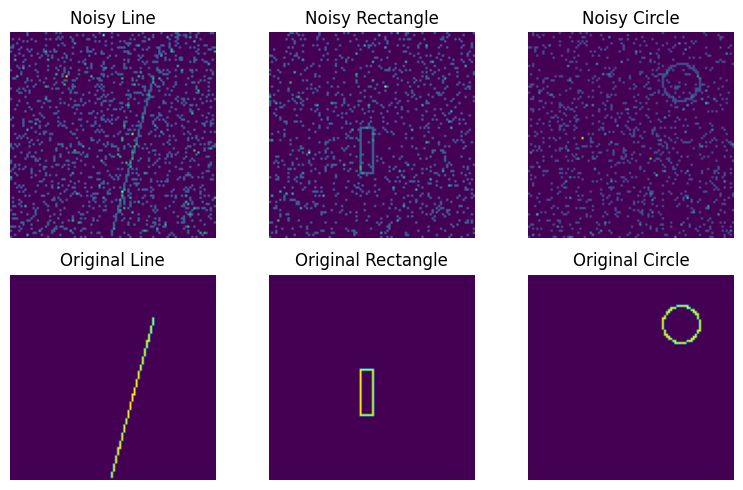

In [13]:
line_idx = np.random.randint(0, 5000)
rectangle_idx = np.random.randint(5000, 10000)
circle_idx = np.random.randint(10000, 15000)

fig, ax = plt.subplots(2, 3, figsize=(8, 5))

ax[0,0].imshow(noisy_data[line_idx])
ax[0,0].set_title('Noisy Line')
ax[0,0].axis('off')
ax[0,1].imshow(noisy_data[rectangle_idx])
ax[0,1].set_title('Noisy Rectangle')
ax[0,1].axis('off')
ax[0,2].imshow(noisy_data[circle_idx])
ax[0,2].set_title('Noisy Circle')
ax[0,2].axis('off')
ax[1,0].imshow(data[line_idx])
ax[1,0].set_title('Original Line')
ax[1,0].axis('off')
ax[1,1].imshow(data[rectangle_idx])
ax[1,1].set_title('Original Rectangle')
ax[1,1].axis('off')
ax[1,2].imshow(data[circle_idx])
ax[1,2].set_title('Original Circle')
ax[1,2].axis('off')
print(
'center_x', rectangle_params['center_x'][rectangle_idx-5000]
,'\ncenter_y', rectangle_params['center_y'][rectangle_idx-5000]
,'\nwidth', rectangle_params['width'][rectangle_idx-5000]
,'\nheight', rectangle_params['height'][rectangle_idx-5000]
)
plt.tight_layout()
plt.show()

In [14]:
#### split the data into train and test
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

In [16]:
x_train, x_test, y_train, y_test, snr_train, snr_test = train_test_split(data, labels, snrs, test_size=0.2, random_state=42)
x_train_noisy, x_test_noisy, y_train_noisy, y_test_noisy, snr_train_noisy, snr_test_noisy = train_test_split(noisy_data, noisy_labels, snrs, test_size=0.2, random_state=41)

In [17]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, snr_train.shape, snr_test.shape)

(12000, 100, 100, 1) (3000, 100, 100, 1) (12000,) (3000,) (12000,) (3000,)


In [18]:
print(x_train_noisy.shape, x_test_noisy.shape, y_train_noisy.shape, y_test_noisy.shape, snr_train_noisy.shape, snr_test_noisy.shape)

(12000, 100, 100, 1) (3000, 100, 100, 1) (12000,) (3000,) (12000,) (3000,)
